In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    outputs = pickle.load(fp)

In [ ]:
# inputs = np.reshape(complete_inputs[:,0:3,:,:], (complete_inputs.shape[0], 3, complete_inputs.shape[2], complete_inputs.shape[3]))


In [3]:
# Sanity check
print(inputs.shape)
print(outputs.shape)

(25650, 4, 32, 32)
(25650, 1, 32, 32)


In [4]:
outputs[outputs > 0] = 1

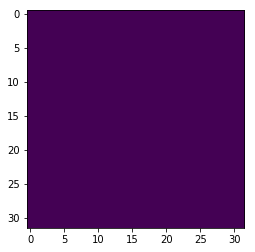

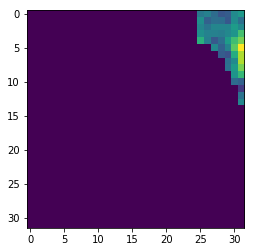

In [5]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*80/100)
val_cutoff = int(inputs.shape[0]*90/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

20520
20520
2565
2565
2565
2565


In [8]:
train_inputs = np.asarray(train_inputs).astype(np.float32)
val_inputs = np.asarray(val_inputs).astype(np.float32)
test_inputs = np.asarray(test_inputs).astype(np.float32)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [9]:
train_outputs = np.asarray(train_outputs).astype(np.float32)
n_tumor_pixels = np.count_nonzero(train_outputs)
total_output_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
frac_tumor = n_tumor_pixels / total_output_pixels
print(frac_tumor)

0.06759054618969298


In [10]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

print(len(train_loader))
print(len(train_data))

642
20520


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial
print(torch.cuda.is_available())

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

True
using device: cuda


In [13]:
from models.unet import *

In [14]:
"""
in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
"""
def test_UNet():
    channels_in = 4
    n_classes = 2
    x = torch.zeros((32, 4, 32, 32), dtype=dtype)
    model = UNet(channel_in=channels_in, classes=n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([32, 2, 32, 32])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [52]:
# Defining all parameters 
print_every = 25
loss_history = []
learning_rate = 0.5e-2
input_channels = 4
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99), eps=1e-08, weight_decay=learning_rate/float(250), amsgrad=False)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 
# could try dice loss? not sure how it would work nor how it expects its parameters though lol

if USE_GPU and torch.cuda.is_available():
    model.cuda()

In [16]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [17]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [18]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)     

In [19]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [20]:
check_iou(val_loader, model)

array([0.93777044, 0.        ])

In [21]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [53]:
import torch.nn.functional as F
train_loss_history = []
val_loss_history = []
cur_epoch_train_loss = []
cur_epoch_val_loss = []
averaged_train_loss_hist = []
averaged_val_loss_history = []
val_iou_history = []
train_iou_history = []

plot_every = 100
def train(model, optimizer, epochs=1):
    
    model = model.to(device=device)
    
    train_loss_history.clear()
    val_loss_history.clear()
    cur_epoch_train_loss.clear()
    cur_epoch_val_loss.clear()
    averaged_train_loss_hist.clear()
    averaged_val_loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    
    for e in range(epochs):
        cur_epoch_train_loss.clear()
        cur_epoch_val_loss.clear()
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            train_scores = model(x)
            train_loss = criterion(train_scores, labels)
            train_loss_history.append(train_loss.item())
            cur_epoch_train_loss.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, train_loss.item()))
                val_iou = check_iou(val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)

        for t, (x,y) in enumerate(val_loader):
            model.eval()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            
            val_scores = model(x)
            val_loss = criterion(val_scores, labels)
            val_loss_history.append(val_loss.item())
            cur_epoch_val_loss.append(val_loss.item())
            
        averaged_train_loss_hist.append(np.mean(np.asarray(cur_epoch_train_loss)))
        averaged_val_loss_history.append(np.mean(np.asarray(cur_epoch_val_loss)))
        print('Epoch %d, Average Training Loss = %.4f, Average Validation Loss = %.4f' % \
              (e, np.mean(np.asarray(cur_epoch_train_loss)), np.mean(np.asarray(cur_epoch_val_loss))))

In [54]:
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 0.6925
Validation IOU:  [0.66839794 0.02884624]
Training IOU:  [0.66809751 0.03036961]
Epoch 0, Iteration 25, loss = 0.6523
Validation IOU:  [0.48305937 0.066449  ]
Training IOU:  [0.48484815 0.07118209]
Epoch 0, Iteration 50, loss = 0.6208
Validation IOU:  [0.7264146  0.04921463]
Training IOU:  [0.7224534  0.05157829]
Epoch 0, Iteration 75, loss = 0.5783
Validation IOU:  [0.58425477 0.06479481]
Training IOU:  [0.58266131 0.06648295]
Epoch 0, Iteration 100, loss = 0.6096
Validation IOU:  [0.62073988 0.06149069]
Training IOU:  [0.62018963 0.0660694 ]
Epoch 0, Iteration 125, loss = 0.5495
Validation IOU:  [0.62738219 0.06321268]
Training IOU:  [0.62868855 0.07012832]
Epoch 0, Iteration 150, loss = 0.5258
Validation IOU:  [0.61239034 0.06252053]
Training IOU:  [0.61043916 0.06627757]
Epoch 0, Iteration 175, loss = 0.6311
Validation IOU:  [0.58668205 0.06466999]
Training IOU:  [0.58778129 0.06842548]
Epoch 0, Iteration 200, loss = 0.5505
Validation IOU:  [0.645

Validation IOU:  [0.73075889 0.07289755]
Training IOU:  [0.7349424  0.08023991]
Epoch 2, Iteration 425, loss = 0.4744
Validation IOU:  [0.71731358 0.07430854]
Training IOU:  [0.72065364 0.07922827]
Epoch 2, Iteration 450, loss = 0.4886
Validation IOU:  [0.75374513 0.06875582]
Training IOU:  [0.75670911 0.07496965]
Epoch 2, Iteration 475, loss = 0.5599
Validation IOU:  [0.73132313 0.07094638]
Training IOU:  [0.73151376 0.07715884]
Epoch 2, Iteration 500, loss = 0.4989
Validation IOU:  [0.71324156 0.07271293]
Training IOU:  [0.71396713 0.07922571]
Epoch 2, Iteration 525, loss = 0.4987
Validation IOU:  [0.76616317 0.0717919 ]
Training IOU:  [0.76714714 0.07602668]
Epoch 2, Iteration 550, loss = 0.6093
Validation IOU:  [0.77217932 0.07088051]
Training IOU:  [0.77440784 0.07643116]
Epoch 2, Iteration 575, loss = 0.5054
Validation IOU:  [0.65743853 0.07450461]
Training IOU:  [0.66028215 0.08238775]
Epoch 2, Iteration 600, loss = 0.6138
Validation IOU:  [0.74034478 0.07174225]
Training IOU:  

Validation IOU:  [0.77462089 0.07378804]
Training IOU:  [0.7763826  0.08051936]
Epoch 5, Iteration 175, loss = 0.4918
Validation IOU:  [0.77192322 0.073996  ]
Training IOU:  [0.77491753 0.07968719]
Epoch 5, Iteration 200, loss = 0.5379
Validation IOU:  [0.77770849 0.07272538]
Training IOU:  [0.77996769 0.08065229]
Epoch 5, Iteration 225, loss = 0.5116
Validation IOU:  [0.76938689 0.07805831]
Training IOU:  [0.77391067 0.08436724]
Epoch 5, Iteration 250, loss = 0.5126
Validation IOU:  [0.80677247 0.07011138]
Training IOU:  [0.81067372 0.07744294]
Epoch 5, Iteration 275, loss = 0.5345
Validation IOU:  [0.75365806 0.07795389]
Training IOU:  [0.7540659  0.08346497]
Epoch 5, Iteration 300, loss = 0.4185
Validation IOU:  [0.76970506 0.07293877]
Training IOU:  [0.77569019 0.08058449]
Epoch 5, Iteration 325, loss = 0.4488
Validation IOU:  [0.77263779 0.07272248]
Training IOU:  [0.7772083  0.07913738]
Epoch 5, Iteration 350, loss = 0.4621
Validation IOU:  [0.7660777  0.07192884]
Training IOU:  

Epoch 7, Iteration 575, loss = 0.4237
Validation IOU:  [0.79793723 0.075758  ]
Training IOU:  [0.8032713 0.0836872]
Epoch 7, Iteration 600, loss = 0.4479
Validation IOU:  [0.77513165 0.07584307]
Training IOU:  [0.78048545 0.08460466]
Epoch 7, Iteration 625, loss = 0.4702
Validation IOU:  [0.79189747 0.0793135 ]
Training IOU:  [0.79517348 0.08743808]
Epoch 7, Average Training Loss = 0.4839, Average Validation Loss = 0.4911
Epoch 8, Iteration 0, loss = 0.5078
Validation IOU:  [0.80302394 0.07635945]
Training IOU:  [0.80505464 0.08350625]
Epoch 8, Iteration 25, loss = 0.5048
Validation IOU:  [0.77558095 0.07524521]
Training IOU:  [0.78091904 0.08559953]
Epoch 8, Iteration 50, loss = 0.5449
Validation IOU:  [0.78112823 0.07589388]
Training IOU:  [0.78977576 0.08645991]
Epoch 8, Iteration 75, loss = 0.5270
Validation IOU:  [0.81895977 0.07397066]
Training IOU:  [0.82766537 0.08411801]
Epoch 8, Iteration 100, loss = 0.4770
Validation IOU:  [0.81615141 0.07994743]
Training IOU:  [0.81955919 0

Epoch 10, Iteration 325, loss = 0.4345
Validation IOU:  [0.7787923  0.07615576]
Training IOU:  [0.78762148 0.08859125]
Epoch 10, Iteration 350, loss = 0.4671
Validation IOU:  [0.79637161 0.07714884]
Training IOU:  [0.80520505 0.08820275]
Epoch 10, Iteration 375, loss = 0.4618
Validation IOU:  [0.79950172 0.07748732]
Training IOU:  [0.80507176 0.08829213]
Epoch 10, Iteration 400, loss = 0.4073
Validation IOU:  [0.81276791 0.07365309]
Training IOU:  [0.82177648 0.0843987 ]
Epoch 10, Iteration 425, loss = 0.4042
Validation IOU:  [0.7830926  0.08189046]
Training IOU:  [0.78632942 0.08874475]
Epoch 10, Iteration 450, loss = 0.5647
Validation IOU:  [0.71934617 0.08137746]
Training IOU:  [0.72501561 0.08702864]
Epoch 10, Iteration 475, loss = 0.5374
Validation IOU:  [0.749823  0.0798535]
Training IOU:  [0.75496288 0.09092964]
Epoch 10, Iteration 500, loss = 0.6392
Validation IOU:  [0.81327093 0.075355  ]
Training IOU:  [0.82303433 0.08862941]
Epoch 10, Iteration 525, loss = 0.4259
Validation 

Validation IOU:  [0.80521491 0.07973301]
Training IOU:  [0.81172866 0.0887967 ]
Epoch 13, Iteration 75, loss = 0.5298
Validation IOU:  [0.82059934 0.07844024]
Training IOU:  [0.82870099 0.08846188]
Epoch 13, Iteration 100, loss = 0.4432
Validation IOU:  [0.83691535 0.07705856]
Training IOU:  [0.84491084 0.08836319]
Epoch 13, Iteration 125, loss = 0.4910
Validation IOU:  [0.76907407 0.08105355]
Training IOU:  [0.77694054 0.09119442]
Epoch 13, Iteration 150, loss = 0.3991
Validation IOU:  [0.77023838 0.08120202]
Training IOU:  [0.77395967 0.09019384]
Epoch 13, Iteration 175, loss = 0.5215
Validation IOU:  [0.7976332  0.07926863]
Training IOU:  [0.80400496 0.08954199]
Epoch 13, Iteration 200, loss = 0.5044
Validation IOU:  [0.78397383 0.07807887]
Training IOU:  [0.79257215 0.08620361]
Epoch 13, Iteration 225, loss = 0.4254
Validation IOU:  [0.80402261 0.08131855]
Training IOU:  [0.81327739 0.08979912]
Epoch 13, Iteration 250, loss = 0.4075
Validation IOU:  [0.76918225 0.07969029]
Training

Validation IOU:  [0.80450571 0.0831933 ]
Training IOU:  [0.81223696 0.09300984]
Epoch 15, Iteration 475, loss = 0.4523
Validation IOU:  [0.79929482 0.08172477]
Training IOU:  [0.81016576 0.09300516]
Epoch 15, Iteration 500, loss = 0.4280
Validation IOU:  [0.76534279 0.08141714]
Training IOU:  [0.77427747 0.09150143]
Epoch 15, Iteration 525, loss = 0.5329
Validation IOU:  [0.78849182 0.07895203]
Training IOU:  [0.79837441 0.08949585]
Epoch 15, Iteration 550, loss = 0.4556
Validation IOU:  [0.78805664 0.08167022]
Training IOU:  [0.79656325 0.09375939]
Epoch 15, Iteration 575, loss = 0.5345
Validation IOU:  [0.79097306 0.08078233]
Training IOU:  [0.79780461 0.09002424]
Epoch 15, Iteration 600, loss = 0.3848
Validation IOU:  [0.79575481 0.07935747]
Training IOU:  [0.80575502 0.09168367]
Epoch 15, Iteration 625, loss = 0.4494
Validation IOU:  [0.78942784 0.08083484]
Training IOU:  [0.80205824 0.09186128]
Epoch 15, Average Training Loss = 0.4533, Average Validation Loss = 0.4663
Epoch 16, It

Epoch 18, Iteration 200, loss = 0.4185
Validation IOU:  [0.80626863 0.08347394]
Training IOU:  [0.81365314 0.09290001]
Epoch 18, Iteration 225, loss = 0.4920
Validation IOU:  [0.8185274  0.07636343]
Training IOU:  [0.82839888 0.0904867 ]
Epoch 18, Iteration 250, loss = 0.3841
Validation IOU:  [0.80839319 0.0811252 ]
Training IOU:  [0.81892784 0.09367978]
Epoch 18, Iteration 275, loss = 0.3964
Validation IOU:  [0.81043929 0.07789738]
Training IOU:  [0.82111008 0.09066368]
Epoch 18, Iteration 300, loss = 0.4839
Validation IOU:  [0.7923463  0.08151008]
Training IOU:  [0.79889986 0.09454695]
Epoch 18, Iteration 325, loss = 0.4425
Validation IOU:  [0.80585461 0.07572455]
Training IOU:  [0.81760975 0.08682244]
Epoch 18, Iteration 350, loss = 0.5514
Validation IOU:  [0.82639784 0.07745083]
Training IOU:  [0.83255502 0.08839366]
Epoch 18, Iteration 375, loss = 0.4228
Validation IOU:  [0.8063477 0.0808017]
Training IOU:  [0.81471788 0.09236171]
Epoch 18, Iteration 400, loss = 0.5036
Validation 

Epoch 20, Iteration 600, loss = 0.4547
Validation IOU:  [0.78573442 0.08040389]
Training IOU:  [0.79843916 0.09215372]
Epoch 20, Iteration 625, loss = 0.4646
Validation IOU:  [0.80835438 0.0805018 ]
Training IOU:  [0.81857497 0.09259744]
Epoch 20, Average Training Loss = 0.4445, Average Validation Loss = 0.4656
Epoch 21, Iteration 0, loss = 0.4576
Validation IOU:  [0.83603665 0.07862746]
Training IOU:  [0.84619128 0.09140315]
Epoch 21, Iteration 25, loss = 0.3813
Validation IOU:  [0.83163108 0.08083222]
Training IOU:  [0.84119309 0.09371232]
Epoch 21, Iteration 50, loss = 0.4060
Validation IOU:  [0.82302809 0.08223687]
Training IOU:  [0.83231881 0.09360422]
Epoch 21, Iteration 75, loss = 0.4577
Validation IOU:  [0.82800245 0.0795284 ]
Training IOU:  [0.83643907 0.09183159]
Epoch 21, Iteration 100, loss = 0.3875
Validation IOU:  [0.79813234 0.0787756 ]
Training IOU:  [0.80646911 0.09105013]
Epoch 21, Iteration 125, loss = 0.4425
Validation IOU:  [0.79798596 0.08308064]
Training IOU:  [0

Validation IOU:  [0.79426343 0.07821096]
Training IOU:  [0.80377442 0.09348429]
Epoch 23, Iteration 350, loss = 0.5107
Validation IOU:  [0.81104746 0.07606258]
Training IOU:  [0.82104818 0.09017513]
Epoch 23, Iteration 375, loss = 0.4107
Validation IOU:  [0.78213096 0.07845956]
Training IOU:  [0.79327909 0.0917572 ]
Epoch 23, Iteration 400, loss = 0.3952
Validation IOU:  [0.81933238 0.07942541]
Training IOU:  [0.82862344 0.09271251]
Epoch 23, Iteration 425, loss = 0.4065
Validation IOU:  [0.80478486 0.07615477]
Training IOU:  [0.81509015 0.09116581]
Epoch 23, Iteration 450, loss = 0.4231
Validation IOU:  [0.84263946 0.07684597]
Training IOU:  [0.85210196 0.09146755]
Epoch 23, Iteration 475, loss = 0.6202
Validation IOU:  [0.80524874 0.08347939]
Training IOU:  [0.81655376 0.09412064]
Epoch 23, Iteration 500, loss = 0.5905
Validation IOU:  [0.80622908 0.0806593 ]
Training IOU:  [0.81923875 0.0939007 ]
Epoch 23, Iteration 525, loss = 0.4550
Validation IOU:  [0.8002386 0.0793967]
Training 

Epoch 26, Iteration 75, loss = 0.4384
Validation IOU:  [0.82972187 0.07944396]
Training IOU:  [0.83896091 0.09393167]
Epoch 26, Iteration 100, loss = 0.4551
Validation IOU:  [0.8375958  0.07784073]
Training IOU:  [0.85188762 0.09431022]
Epoch 26, Iteration 125, loss = 0.5279
Validation IOU:  [0.80859385 0.08149463]
Training IOU:  [0.81784002 0.09623825]
Epoch 26, Iteration 150, loss = 0.4653
Validation IOU:  [0.77267859 0.0822198 ]
Training IOU:  [0.78477817 0.09349031]
Epoch 26, Iteration 175, loss = 0.3978
Validation IOU:  [0.82746313 0.07783945]
Training IOU:  [0.83542685 0.09301572]
Epoch 26, Iteration 200, loss = 0.4007
Validation IOU:  [0.84818189 0.07772084]
Training IOU:  [0.8565621  0.09226088]
Epoch 26, Iteration 225, loss = 0.4505
Validation IOU:  [0.83226192 0.07712839]
Training IOU:  [0.84126993 0.09313985]
Epoch 26, Iteration 250, loss = 0.5417
Validation IOU:  [0.81838649 0.07690917]
Training IOU:  [0.82659766 0.09085875]
Epoch 26, Iteration 275, loss = 0.4696
Validation

Epoch 28, Iteration 475, loss = 0.4304
Validation IOU:  [0.82155262 0.07759346]
Training IOU:  [0.83530585 0.09457192]
Epoch 28, Iteration 500, loss = 0.4239
Validation IOU:  [0.83090483 0.07584411]
Training IOU:  [0.84301509 0.09285029]
Epoch 28, Iteration 525, loss = 0.3786
Validation IOU:  [0.81596869 0.07665761]
Training IOU:  [0.82978256 0.09068831]
Epoch 28, Iteration 550, loss = 0.4386
Validation IOU:  [0.78484333 0.07879069]
Training IOU:  [0.79745505 0.09304401]
Epoch 28, Iteration 575, loss = 0.5072
Validation IOU:  [0.80170766 0.0795898 ]
Training IOU:  [0.81321332 0.09296575]
Epoch 28, Iteration 600, loss = 0.3935
Validation IOU:  [0.81787884 0.0802589 ]
Training IOU:  [0.8326458  0.09401044]
Epoch 28, Iteration 625, loss = 0.4246
Validation IOU:  [0.81399791 0.07864423]
Training IOU:  [0.82833759 0.09586948]
Epoch 28, Average Training Loss = 0.4366, Average Validation Loss = 0.4837
Epoch 29, Iteration 0, loss = 0.4931
Validation IOU:  [0.80537618 0.07450803]
Training IOU: 

Validation IOU:  [0.8088986  0.07880443]
Training IOU:  [0.81973912 0.09542008]
Epoch 31, Iteration 225, loss = 0.3839
Validation IOU:  [0.8079764  0.07464272]
Training IOU:  [0.82231348 0.09094459]
Epoch 31, Iteration 250, loss = 0.3732
Validation IOU:  [0.82389709 0.07614385]
Training IOU:  [0.83502687 0.09185096]
Epoch 31, Iteration 275, loss = 0.4093
Validation IOU:  [0.81497086 0.08010202]
Training IOU:  [0.82869179 0.09636085]
Epoch 31, Iteration 300, loss = 0.3807
Validation IOU:  [0.81509684 0.07996584]
Training IOU:  [0.83213824 0.09565091]
Epoch 31, Iteration 325, loss = 0.4548
Validation IOU:  [0.80741098 0.07690504]
Training IOU:  [0.82386148 0.09332668]
Epoch 31, Iteration 350, loss = 0.4360
Validation IOU:  [0.81103543 0.07745731]
Training IOU:  [0.82618006 0.09303947]
Epoch 31, Iteration 375, loss = 0.4374
Validation IOU:  [0.84056053 0.07771741]
Training IOU:  [0.85730943 0.09434146]
Epoch 31, Iteration 400, loss = 0.4419
Validation IOU:  [0.80818439 0.07794734]
Trainin

Validation IOU:  [0.8090359  0.07638656]
Training IOU:  [0.8219958  0.09172889]
Epoch 33, Iteration 625, loss = 0.4800
Validation IOU:  [0.84133496 0.07405156]
Training IOU:  [0.85336564 0.09135453]
Epoch 33, Average Training Loss = 0.4333, Average Validation Loss = 0.4734
Epoch 34, Iteration 0, loss = 0.4343
Validation IOU:  [0.75986256 0.08084283]
Training IOU:  [0.77099662 0.09287309]
Epoch 34, Iteration 25, loss = 0.3893
Validation IOU:  [0.80816165 0.08054658]
Training IOU:  [0.82101998 0.09449446]
Epoch 34, Iteration 50, loss = 0.4188
Validation IOU:  [0.82939237 0.07945346]
Training IOU:  [0.84437815 0.09582413]
Epoch 34, Iteration 75, loss = 0.3838
Validation IOU:  [0.83697257 0.07647025]
Training IOU:  [0.84862502 0.09227795]
Epoch 34, Iteration 100, loss = 0.4341
Validation IOU:  [0.80332385 0.07747899]
Training IOU:  [0.81608531 0.09466108]
Epoch 34, Iteration 125, loss = 0.4336
Validation IOU:  [0.82559096 0.07675694]
Training IOU:  [0.83833108 0.09372396]
Epoch 34, Iterati

Epoch 36, Iteration 350, loss = 0.5487
Validation IOU:  [0.79369591 0.08081159]
Training IOU:  [0.8086138  0.09240818]
Epoch 36, Iteration 375, loss = 0.4060
Validation IOU:  [0.80802941 0.07915411]
Training IOU:  [0.82199336 0.09367792]
Epoch 36, Iteration 400, loss = 0.4341
Validation IOU:  [0.80227786 0.07852447]
Training IOU:  [0.81595969 0.09403366]
Epoch 36, Iteration 425, loss = 0.4289
Validation IOU:  [0.8223998  0.07740752]
Training IOU:  [0.83541116 0.09621853]
Epoch 36, Iteration 450, loss = 0.3938
Validation IOU:  [0.80256453 0.0791488 ]
Training IOU:  [0.81478943 0.09505248]
Epoch 36, Iteration 475, loss = 0.3795
Validation IOU:  [0.80291792 0.07581672]
Training IOU:  [0.81524863 0.09305156]
Epoch 36, Iteration 500, loss = 0.4039
Validation IOU:  [0.85107036 0.07669666]
Training IOU:  [0.86127488 0.09097777]
Epoch 36, Iteration 525, loss = 0.3938
Validation IOU:  [0.79947017 0.07631802]
Training IOU:  [0.81145209 0.09131708]
Epoch 36, Iteration 550, loss = 0.5129
Validatio

Validation IOU:  [0.82691693 0.07901115]
Training IOU:  [0.84418054 0.09405765]
Epoch 39, Iteration 100, loss = 0.4114
Validation IOU:  [0.83209181 0.07984485]
Training IOU:  [0.8454708 0.096185 ]
Epoch 39, Iteration 125, loss = 0.3876
Validation IOU:  [0.81703804 0.08011249]
Training IOU:  [0.82755331 0.09539779]
Epoch 39, Iteration 150, loss = 0.4070
Validation IOU:  [0.81539117 0.07818071]
Training IOU:  [0.82700054 0.09695765]
Epoch 39, Iteration 175, loss = 0.4159
Validation IOU:  [0.82715112 0.07781777]
Training IOU:  [0.84177816 0.094733  ]
Epoch 39, Iteration 200, loss = 0.4200
Validation IOU:  [0.81544317 0.07986002]
Training IOU:  [0.82778238 0.09544642]
Epoch 39, Iteration 225, loss = 0.3978
Validation IOU:  [0.83499182 0.08077301]
Training IOU:  [0.84751765 0.0963942 ]
Epoch 39, Iteration 250, loss = 0.3966
Validation IOU:  [0.8180404  0.07870342]
Training IOU:  [0.83380074 0.0969607 ]
Epoch 39, Iteration 275, loss = 0.4544
Validation IOU:  [0.81586487 0.0772429 ]
Training 

Validation IOU:  [0.83448842 0.07684541]
Training IOU:  [0.84756991 0.0960544 ]
Epoch 41, Iteration 500, loss = 0.4940
Validation IOU:  [0.8405693  0.07822007]
Training IOU:  [0.85190598 0.09662546]
Epoch 41, Iteration 525, loss = 0.4421
Validation IOU:  [0.82628051 0.07827524]
Training IOU:  [0.84026799 0.09643321]
Epoch 41, Iteration 550, loss = 0.4064
Validation IOU:  [0.85803225 0.0748183 ]
Training IOU:  [0.86891171 0.09454972]
Epoch 41, Iteration 575, loss = 0.4336
Validation IOU:  [0.8235476  0.07970915]
Training IOU:  [0.83610657 0.09672167]
Epoch 41, Iteration 600, loss = 0.4115
Validation IOU:  [0.81098258 0.07375536]
Training IOU:  [0.82563951 0.09230802]
Epoch 41, Iteration 625, loss = 0.4095
Validation IOU:  [0.81832156 0.08036401]
Training IOU:  [0.83265804 0.09573692]
Epoch 41, Average Training Loss = 0.4237, Average Validation Loss = 0.4954
Epoch 42, Iteration 0, loss = 0.3901
Validation IOU:  [0.85018541 0.07750897]
Training IOU:  [0.86465618 0.09649445]
Epoch 42, Iter

Epoch 44, Iteration 225, loss = 0.3763
Validation IOU:  [0.84593045 0.07473699]
Training IOU:  [0.8596935  0.09357838]
Epoch 44, Iteration 250, loss = 0.5774
Validation IOU:  [0.81407662 0.08186357]
Training IOU:  [0.82994035 0.096698  ]
Epoch 44, Iteration 275, loss = 0.5410
Validation IOU:  [0.83610599 0.07527452]
Training IOU:  [0.8495594  0.09522066]
Epoch 44, Iteration 300, loss = 0.3937
Validation IOU:  [0.8458503  0.07471599]
Training IOU:  [0.85978361 0.09572567]
Epoch 44, Iteration 325, loss = 0.4624
Validation IOU:  [0.84092095 0.07829819]
Training IOU:  [0.85295703 0.09443086]
Epoch 44, Iteration 350, loss = 0.4038
Validation IOU:  [0.83546806 0.07600414]
Training IOU:  [0.84665558 0.09454953]
Epoch 44, Iteration 375, loss = 0.4839
Validation IOU:  [0.84233009 0.07513146]
Training IOU:  [0.85267132 0.09412066]
Epoch 44, Iteration 400, loss = 0.4473
Validation IOU:  [0.79639228 0.08181288]
Training IOU:  [0.80652365 0.09732941]
Epoch 44, Iteration 425, loss = 0.4157
Validatio

Epoch 46, Iteration 625, loss = 0.3881
Validation IOU:  [0.81805493 0.07639259]
Training IOU:  [0.83219097 0.09303024]
Epoch 46, Average Training Loss = 0.4217, Average Validation Loss = 0.4744
Epoch 47, Iteration 0, loss = 0.4053
Validation IOU:  [0.82520659 0.07667824]
Training IOU:  [0.8377753  0.09357111]
Epoch 47, Iteration 25, loss = 0.4754
Validation IOU:  [0.85520655 0.07687163]
Training IOU:  [0.86816901 0.09298539]
Epoch 47, Iteration 50, loss = 0.4607
Validation IOU:  [0.815856   0.07594934]
Training IOU:  [0.83247329 0.09477406]
Epoch 47, Iteration 75, loss = 0.4032
Validation IOU:  [0.83355607 0.07885381]
Training IOU:  [0.84435613 0.09682953]
Epoch 47, Iteration 100, loss = 0.3775
Validation IOU:  [0.84506941 0.07108028]
Training IOU:  [0.85739854 0.09307716]
Epoch 47, Iteration 125, loss = 0.4002
Validation IOU:  [0.85307218 0.07287425]
Training IOU:  [0.86235875 0.09379105]
Epoch 47, Iteration 150, loss = 0.3841
Validation IOU:  [0.8259866  0.07296819]
Training IOU:  [0

Validation IOU:  [0.84375095 0.07439318]
Training IOU:  [0.85900019 0.09652322]
Epoch 49, Iteration 375, loss = 0.4895
Validation IOU:  [0.81805827 0.07732277]
Training IOU:  [0.83132334 0.09513763]
Epoch 49, Iteration 400, loss = 0.3868
Validation IOU:  [0.84709803 0.07276662]
Training IOU:  [0.86111085 0.09371141]
Epoch 49, Iteration 425, loss = 0.3751
Validation IOU:  [0.81983233 0.07589168]
Training IOU:  [0.83650978 0.09524784]
Epoch 49, Iteration 450, loss = 0.4382
Validation IOU:  [0.80345214 0.0783187 ]
Training IOU:  [0.82027259 0.09546117]
Epoch 49, Iteration 475, loss = 0.3989
Validation IOU:  [0.84032013 0.07803643]
Training IOU:  [0.85696436 0.09649533]
Epoch 49, Iteration 500, loss = 0.3834
Validation IOU:  [0.82581324 0.07729077]
Training IOU:  [0.83973998 0.09721132]
Epoch 49, Iteration 525, loss = 0.4454
Validation IOU:  [0.80864206 0.07526028]
Training IOU:  [0.82357271 0.09431882]
Epoch 49, Iteration 550, loss = 0.3998
Validation IOU:  [0.82906316 0.07542075]
Trainin

Epoch 52, Iteration 100, loss = 0.4111
Validation IOU:  [0.84957726 0.07490508]
Training IOU:  [0.86492587 0.09667429]
Epoch 52, Iteration 125, loss = 0.4292
Validation IOU:  [0.82203411 0.07599051]
Training IOU:  [0.83869289 0.09541769]
Epoch 52, Iteration 150, loss = 0.3571
Validation IOU:  [0.82260005 0.0745198 ]
Training IOU:  [0.83961015 0.09666896]
Epoch 52, Iteration 175, loss = 0.4086
Validation IOU:  [0.80544056 0.07719789]
Training IOU:  [0.8193594  0.09523301]
Epoch 52, Iteration 200, loss = 0.3610
Validation IOU:  [0.82744073 0.07602594]
Training IOU:  [0.84451081 0.09753795]
Epoch 52, Iteration 225, loss = 0.3621
Validation IOU:  [0.85156279 0.07526307]
Training IOU:  [0.86428087 0.09232679]
Epoch 52, Iteration 250, loss = 0.4622
Validation IOU:  [0.82809666 0.07697348]
Training IOU:  [0.84565985 0.09626647]
Epoch 52, Iteration 275, loss = 0.4260
Validation IOU:  [0.85066093 0.07634298]
Training IOU:  [0.87009785 0.09776714]
Epoch 52, Iteration 300, loss = 0.3588
Validatio

Epoch 54, Iteration 500, loss = 0.4179
Validation IOU:  [0.84161782 0.07913053]
Training IOU:  [0.85625833 0.09751454]
Epoch 54, Iteration 525, loss = 0.4159
Validation IOU:  [0.81463233 0.07720254]
Training IOU:  [0.83036666 0.09741511]
Epoch 54, Iteration 550, loss = 0.3813
Validation IOU:  [0.83776997 0.07856084]
Training IOU:  [0.85090513 0.09719802]
Epoch 54, Iteration 575, loss = 0.4068
Validation IOU:  [0.80961881 0.07817316]
Training IOU:  [0.82832674 0.095562  ]
Epoch 54, Iteration 600, loss = 0.4233
Validation IOU:  [0.8130506  0.07931567]
Training IOU:  [0.82858483 0.09567874]
Epoch 54, Iteration 625, loss = 0.3702
Validation IOU:  [0.8028227  0.07535656]
Training IOU:  [0.82105215 0.09344113]
Epoch 54, Average Training Loss = 0.4207, Average Validation Loss = 0.5176
Epoch 55, Iteration 0, loss = 0.4196
Validation IOU:  [0.84200357 0.0753637 ]
Training IOU:  [0.85578577 0.09458852]
Epoch 55, Iteration 25, loss = 0.3889
Validation IOU:  [0.82896307 0.0804289 ]
Training IOU:  

Validation IOU:  [0.83967691 0.07567488]
Training IOU:  [0.85253968 0.09623331]
Epoch 57, Iteration 250, loss = 0.4338
Validation IOU:  [0.84181281 0.07655751]
Training IOU:  [0.85695475 0.09810714]
Epoch 57, Iteration 275, loss = 0.3976
Validation IOU:  [0.8458378  0.07733032]
Training IOU:  [0.85991097 0.09814564]
Epoch 57, Iteration 300, loss = 0.3919
Validation IOU:  [0.82301136 0.07501742]
Training IOU:  [0.83940969 0.09286792]
Epoch 57, Iteration 325, loss = 0.4026
Validation IOU:  [0.8129812  0.07555459]
Training IOU:  [0.82710336 0.09398041]
Epoch 57, Iteration 350, loss = 0.5038
Validation IOU:  [0.8520932  0.07598721]
Training IOU:  [0.86688647 0.09823111]
Epoch 57, Iteration 375, loss = 0.4006
Validation IOU:  [0.83400628 0.07870879]
Training IOU:  [0.84996922 0.09705601]
Epoch 57, Iteration 400, loss = 0.5512
Validation IOU:  [0.84939441 0.07583981]
Training IOU:  [0.86274647 0.09642304]
Epoch 57, Iteration 425, loss = 0.3870
Validation IOU:  [0.8469066  0.07748172]
Trainin

Validation IOU:  [0.81183936 0.07749821]
Training IOU:  [0.8235748  0.09550815]
Epoch 59, Average Training Loss = 0.4159, Average Validation Loss = 0.4936
Epoch 60, Iteration 0, loss = 0.4120
Validation IOU:  [0.8297783  0.07522014]
Training IOU:  [0.84556774 0.09457239]
Epoch 60, Iteration 25, loss = 0.4641
Validation IOU:  [0.85477496 0.0723291 ]
Training IOU:  [0.86838892 0.0959909 ]
Epoch 60, Iteration 50, loss = 0.3936
Validation IOU:  [0.85125455 0.07162642]
Training IOU:  [0.8692757  0.09634046]
Epoch 60, Iteration 75, loss = 0.4316
Validation IOU:  [0.80259874 0.07642708]
Training IOU:  [0.81832846 0.09589494]
Epoch 60, Iteration 100, loss = 0.3616
Validation IOU:  [0.80305818 0.07599266]
Training IOU:  [0.82019045 0.09457132]
Epoch 60, Iteration 125, loss = 0.4445
Validation IOU:  [0.83113913 0.07773347]
Training IOU:  [0.8493032 0.0962469]
Epoch 60, Iteration 150, loss = 0.4037
Validation IOU:  [0.84041778 0.07427214]
Training IOU:  [0.85883224 0.09744779]
Epoch 60, Iteration

Epoch 62, Iteration 375, loss = 0.4355
Validation IOU:  [0.84720845 0.07070513]
Training IOU:  [0.8619143  0.09665084]
Epoch 62, Iteration 400, loss = 0.4426
Validation IOU:  [0.81997349 0.07667135]
Training IOU:  [0.83813923 0.09798861]
Epoch 62, Iteration 425, loss = 0.3740
Validation IOU:  [0.8039639  0.07825881]
Training IOU:  [0.8185823  0.09647271]
Epoch 62, Iteration 450, loss = 0.3538
Validation IOU:  [0.85164444 0.07288924]
Training IOU:  [0.86568008 0.09498897]
Epoch 62, Iteration 475, loss = 0.5044
Validation IOU:  [0.81963035 0.07776007]
Training IOU:  [0.83070374 0.0972    ]
Epoch 62, Iteration 500, loss = 0.3662
Validation IOU:  [0.82398686 0.0725619 ]
Training IOU:  [0.84036827 0.09514397]
Epoch 62, Iteration 525, loss = 0.4130
Validation IOU:  [0.85932693 0.07261766]
Training IOU:  [0.87550005 0.09589346]
Epoch 62, Iteration 550, loss = 0.4472
Validation IOU:  [0.79815885 0.07385851]
Training IOU:  [0.81582203 0.09370058]
Epoch 62, Iteration 575, loss = 0.4999
Validatio

Validation IOU:  [0.83343951 0.073317  ]
Training IOU:  [0.85408313 0.09582928]
Epoch 65, Iteration 125, loss = 0.4014
Validation IOU:  [0.84906077 0.0760768 ]
Training IOU:  [0.86493036 0.09661914]
Epoch 65, Iteration 150, loss = 0.4100
Validation IOU:  [0.85701026 0.07158956]
Training IOU:  [0.87586951 0.09844701]
Epoch 65, Iteration 175, loss = 0.4150
Validation IOU:  [0.8119094  0.07886321]
Training IOU:  [0.83037261 0.0980223 ]
Epoch 65, Iteration 200, loss = 0.3843
Validation IOU:  [0.84511363 0.07483741]
Training IOU:  [0.86259286 0.0972146 ]
Epoch 65, Iteration 225, loss = 0.3973
Validation IOU:  [0.86233853 0.0749494 ]
Training IOU:  [0.87714753 0.09823257]
Epoch 65, Iteration 250, loss = 0.4152
Validation IOU:  [0.82121461 0.0760478 ]
Training IOU:  [0.83688604 0.09729161]
Epoch 65, Iteration 275, loss = 0.4360
Validation IOU:  [0.83599658 0.07496658]
Training IOU:  [0.85297378 0.09602953]
Epoch 65, Iteration 300, loss = 0.4121
Validation IOU:  [0.83043006 0.07651991]
Trainin

Validation IOU:  [0.83043715 0.07214595]
Training IOU:  [0.84418202 0.09397585]
Epoch 67, Iteration 525, loss = 0.4675
Validation IOU:  [0.82451332 0.07361128]
Training IOU:  [0.84024683 0.09608955]
Epoch 67, Iteration 550, loss = 0.3669
Validation IOU:  [0.83490161 0.07472135]
Training IOU:  [0.85014913 0.098744  ]
Epoch 67, Iteration 575, loss = 0.3525
Validation IOU:  [0.85771457 0.07170353]
Training IOU:  [0.87353857 0.09778823]
Epoch 67, Iteration 600, loss = 0.3963
Validation IOU:  [0.86004272 0.07210859]
Training IOU:  [0.87559726 0.098515  ]
Epoch 67, Iteration 625, loss = 0.4071
Validation IOU:  [0.83503466 0.07376872]
Training IOU:  [0.85325309 0.09854974]
Epoch 67, Average Training Loss = 0.4107, Average Validation Loss = 0.5014
Epoch 68, Iteration 0, loss = 0.3782
Validation IOU:  [0.83327896 0.07226002]
Training IOU:  [0.85135427 0.09676523]
Epoch 68, Iteration 25, loss = 0.4643
Validation IOU:  [0.86540272 0.06997117]
Training IOU:  [0.88309722 0.09630678]
Epoch 68, Itera

Epoch 70, Iteration 250, loss = 0.4041
Validation IOU:  [0.84482645 0.07409901]
Training IOU:  [0.86166348 0.09753953]
Epoch 70, Iteration 275, loss = 0.3394
Validation IOU:  [0.86164167 0.07175848]
Training IOU:  [0.87826787 0.09822787]
Epoch 70, Iteration 300, loss = 0.3897
Validation IOU:  [0.83456239 0.07201961]
Training IOU:  [0.85542876 0.0977648 ]
Epoch 70, Iteration 325, loss = 0.4201
Validation IOU:  [0.84418634 0.07237052]
Training IOU:  [0.85969421 0.0969665 ]
Epoch 70, Iteration 350, loss = 0.3931
Validation IOU:  [0.82835163 0.07651735]
Training IOU:  [0.84907497 0.09829014]
Epoch 70, Iteration 375, loss = 0.3544
Validation IOU:  [0.81351425 0.07308309]
Training IOU:  [0.83298619 0.09699587]
Epoch 70, Iteration 400, loss = 0.4338
Validation IOU:  [0.83202245 0.07213989]
Training IOU:  [0.85001385 0.09748434]
Epoch 70, Iteration 425, loss = 0.4203
Validation IOU:  [0.84898222 0.07262803]
Training IOU:  [0.86493256 0.09650213]
Epoch 70, Iteration 450, loss = 0.4266
Validatio

Epoch 72, Average Training Loss = 0.4132, Average Validation Loss = 0.4896
Epoch 73, Iteration 0, loss = 0.3838
Validation IOU:  [0.82086091 0.07519229]
Training IOU:  [0.83784834 0.09847248]
Epoch 73, Iteration 25, loss = 0.3684
Validation IOU:  [0.85829408 0.07326204]
Training IOU:  [0.87548635 0.09951921]
Epoch 73, Iteration 50, loss = 0.4262
Validation IOU:  [0.84287578 0.0722033 ]
Training IOU:  [0.85867355 0.09818748]
Epoch 73, Iteration 75, loss = 0.4145
Validation IOU:  [0.8705495 0.0728106]
Training IOU:  [0.88733011 0.10085579]
Epoch 73, Iteration 100, loss = 0.3727
Validation IOU:  [0.82988838 0.07533221]
Training IOU:  [0.84489307 0.09817472]
Epoch 73, Iteration 125, loss = 0.3793
Validation IOU:  [0.8403474  0.07176691]
Training IOU:  [0.85413573 0.09549405]
Epoch 73, Iteration 150, loss = 0.4030
Validation IOU:  [0.85879146 0.07106297]
Training IOU:  [0.87521938 0.09843056]
Epoch 73, Iteration 175, loss = 0.4374
Validation IOU:  [0.86797667 0.07290603]
Training IOU:  [0.8

Validation IOU:  [0.86147706 0.07168353]
Training IOU:  [0.87739102 0.09782163]
Epoch 75, Iteration 400, loss = 0.4378
Validation IOU:  [0.84505676 0.0738425 ]
Training IOU:  [0.86018347 0.09942134]
Epoch 75, Iteration 425, loss = 0.4126
Validation IOU:  [0.82858505 0.07094127]
Training IOU:  [0.8454698  0.09511423]
Epoch 75, Iteration 450, loss = 0.3945
Validation IOU:  [0.85445562 0.07043727]
Training IOU:  [0.87169604 0.09691322]
Epoch 75, Iteration 475, loss = 0.4261
Validation IOU:  [0.84901779 0.0712012 ]
Training IOU:  [0.86274606 0.09741622]
Epoch 75, Iteration 500, loss = 0.3994
Validation IOU:  [0.84869015 0.07438064]
Training IOU:  [0.86238677 0.09823516]
Epoch 75, Iteration 525, loss = 0.3785
Validation IOU:  [0.85145049 0.07416553]
Training IOU:  [0.86580145 0.0978893 ]
Epoch 75, Iteration 550, loss = 0.4128
Validation IOU:  [0.82683642 0.07690223]
Training IOU:  [0.8413668  0.09792118]
Epoch 75, Iteration 575, loss = 0.3971
Validation IOU:  [0.84945536 0.07565336]
Trainin

Epoch 78, Iteration 125, loss = 0.3805
Validation IOU:  [0.86320892 0.07319988]
Training IOU:  [0.87948595 0.09921856]
Epoch 78, Iteration 150, loss = 0.3803
Validation IOU:  [0.84296023 0.07498076]
Training IOU:  [0.86021418 0.09843865]
Epoch 78, Iteration 175, loss = 0.5568
Validation IOU:  [0.83466748 0.0763326 ]
Training IOU:  [0.85350443 0.09886834]
Epoch 78, Iteration 200, loss = 0.3619
Validation IOU:  [0.84744784 0.07484959]
Training IOU:  [0.86550744 0.09984703]
Epoch 78, Iteration 225, loss = 0.3697
Validation IOU:  [0.8477002  0.07710267]
Training IOU:  [0.86508047 0.09969106]
Epoch 78, Iteration 250, loss = 0.3846
Validation IOU:  [0.83279253 0.07526431]
Training IOU:  [0.85404192 0.09998283]
Epoch 78, Iteration 275, loss = 0.4191
Validation IOU:  [0.83591655 0.07738656]
Training IOU:  [0.84955962 0.09916174]
Epoch 78, Iteration 300, loss = 0.4876
Validation IOU:  [0.82747055 0.07355522]
Training IOU:  [0.8479623  0.09593775]
Epoch 78, Iteration 325, loss = 0.4154
Validatio

Epoch 80, Iteration 525, loss = 0.4280
Validation IOU:  [0.84632574 0.07184942]
Training IOU:  [0.86147576 0.0969371 ]
Epoch 80, Iteration 550, loss = 0.3922
Validation IOU:  [0.83066342 0.07367519]
Training IOU:  [0.84736343 0.09547957]
Epoch 80, Iteration 575, loss = 0.4582
Validation IOU:  [0.84220301 0.07424266]
Training IOU:  [0.85533437 0.09772179]
Epoch 80, Iteration 600, loss = 0.4263
Validation IOU:  [0.81374331 0.07789422]
Training IOU:  [0.83134922 0.09598418]
Epoch 80, Iteration 625, loss = 0.3866
Validation IOU:  [0.80321013 0.07588588]
Training IOU:  [0.82168349 0.0969164 ]
Epoch 80, Average Training Loss = 0.4093, Average Validation Loss = 0.5133
Epoch 81, Iteration 0, loss = 0.4571
Validation IOU:  [0.82835712 0.07376481]
Training IOU:  [0.84567639 0.09730767]
Epoch 81, Iteration 25, loss = 0.4163
Validation IOU:  [0.82542338 0.07561946]
Training IOU:  [0.8417921  0.09684506]
Epoch 81, Iteration 50, loss = 0.3571
Validation IOU:  [0.86847862 0.07163674]
Training IOU:  [

Validation IOU:  [0.84853859 0.07540107]
Training IOU:  [0.86640869 0.09963376]
Epoch 83, Iteration 275, loss = 0.3846
Validation IOU:  [0.84166142 0.07335371]
Training IOU:  [0.85793496 0.0980102 ]
Epoch 83, Iteration 300, loss = 0.3744
Validation IOU:  [0.86551574 0.07114999]
Training IOU:  [0.88343107 0.09899583]
Epoch 83, Iteration 325, loss = 0.3607
Validation IOU:  [0.84322817 0.07267766]
Training IOU:  [0.85784906 0.09717598]
Epoch 83, Iteration 350, loss = 0.4429
Validation IOU:  [0.81401435 0.07470742]
Training IOU:  [0.83023332 0.09545249]
Epoch 83, Iteration 375, loss = 0.3616
Validation IOU:  [0.82810524 0.0742812 ]
Training IOU:  [0.84522705 0.09704692]
Epoch 83, Iteration 400, loss = 0.4665
Validation IOU:  [0.83515232 0.07734307]
Training IOU:  [0.84814903 0.09694004]
Epoch 83, Iteration 425, loss = 0.4060
Validation IOU:  [0.82239096 0.07891418]
Training IOU:  [0.83703707 0.0986222 ]
Epoch 83, Iteration 450, loss = 0.3796
Validation IOU:  [0.83671704 0.07236267]
Trainin

Validation IOU:  [0.83421578 0.07302765]
Training IOU:  [0.85369995 0.09732943]
Epoch 86, Iteration 25, loss = 0.3746
Validation IOU:  [0.85058588 0.07374735]
Training IOU:  [0.86619546 0.09959569]
Epoch 86, Iteration 50, loss = 0.4388
Validation IOU:  [0.84003806 0.07367828]
Training IOU:  [0.8578743  0.09853121]
Epoch 86, Iteration 75, loss = 0.4066
Validation IOU:  [0.84598643 0.07377876]
Training IOU:  [0.86674579 0.09950068]
Epoch 86, Iteration 100, loss = 0.4116
Validation IOU:  [0.8312147  0.07304279]
Training IOU:  [0.85038039 0.09753292]
Epoch 86, Iteration 125, loss = 0.3509
Validation IOU:  [0.85731058 0.07103249]
Training IOU:  [0.87465711 0.09765651]
Epoch 86, Iteration 150, loss = 0.4244
Validation IOU:  [0.86152411 0.07345002]
Training IOU:  [0.8766608  0.09924287]
Epoch 86, Iteration 175, loss = 0.3702
Validation IOU:  [0.84937072 0.07417705]
Training IOU:  [0.86532948 0.10067204]
Epoch 86, Iteration 200, loss = 0.3687
Validation IOU:  [0.85000438 0.07451128]
Training I

Validation IOU:  [0.83915965 0.07682091]
Training IOU:  [0.85349083 0.09909106]
Epoch 88, Iteration 425, loss = 0.4080
Validation IOU:  [0.83573799 0.07363147]
Training IOU:  [0.85175365 0.09579582]
Epoch 88, Iteration 450, loss = 0.3704
Validation IOU:  [0.88229309 0.06904557]
Training IOU:  [0.89607946 0.09853197]
Epoch 88, Iteration 475, loss = 0.4101
Validation IOU:  [0.82245811 0.07368929]
Training IOU:  [0.83829089 0.09432835]
Epoch 88, Iteration 500, loss = 0.4405
Validation IOU:  [0.8142649  0.07369578]
Training IOU:  [0.832897   0.09515778]
Epoch 88, Iteration 525, loss = 0.3773
Validation IOU:  [0.84479326 0.06999134]
Training IOU:  [0.86085855 0.09719215]
Epoch 88, Iteration 550, loss = 0.3685
Validation IOU:  [0.86671286 0.07247729]
Training IOU:  [0.87985974 0.09905431]
Epoch 88, Iteration 575, loss = 0.5988
Validation IOU:  [0.84330211 0.07462684]
Training IOU:  [0.85869375 0.09922376]
Epoch 88, Iteration 600, loss = 0.4339
Validation IOU:  [0.7994783  0.07804426]
Trainin

Epoch 91, Iteration 150, loss = 0.3777
Validation IOU:  [0.85512855 0.07286284]
Training IOU:  [0.87180655 0.09794835]
Epoch 91, Iteration 175, loss = 0.4371
Validation IOU:  [0.87179577 0.06932317]
Training IOU:  [0.8883231  0.09790347]
Epoch 91, Iteration 200, loss = 0.3537
Validation IOU:  [0.80381336 0.07634011]
Training IOU:  [0.82568629 0.09626796]
Epoch 91, Iteration 225, loss = 0.3895
Validation IOU:  [0.84672515 0.07616317]
Training IOU:  [0.86685844 0.09899944]
Epoch 91, Iteration 250, loss = 0.4641
Validation IOU:  [0.83153936 0.07314375]
Training IOU:  [0.85129234 0.09746189]
Epoch 91, Iteration 275, loss = 0.4548
Validation IOU:  [0.87035285 0.06904227]
Training IOU:  [0.88715005 0.09701255]
Epoch 91, Iteration 300, loss = 0.3566
Validation IOU:  [0.84913983 0.07219412]
Training IOU:  [0.86584963 0.09663059]
Epoch 91, Iteration 325, loss = 0.6154
Validation IOU:  [0.84978014 0.07327493]
Training IOU:  [0.86498767 0.09854705]
Epoch 91, Iteration 350, loss = 0.4137
Validatio

Epoch 93, Iteration 550, loss = 0.4039
Validation IOU:  [0.82767742 0.07385808]
Training IOU:  [0.84656005 0.09689368]
Epoch 93, Iteration 575, loss = 0.4487
Validation IOU:  [0.8596893 0.0733246]
Training IOU:  [0.8751066  0.09857175]
Epoch 93, Iteration 600, loss = 0.3758
Validation IOU:  [0.84139771 0.07581156]
Training IOU:  [0.8567878  0.09671727]
Epoch 93, Iteration 625, loss = 0.4262
Validation IOU:  [0.85048585 0.07371336]
Training IOU:  [0.8662733  0.09866179]
Epoch 93, Average Training Loss = 0.4083, Average Validation Loss = 0.5023
Epoch 94, Iteration 0, loss = 0.3697
Validation IOU:  [0.86731454 0.06997098]
Training IOU:  [0.88041141 0.09947937]
Epoch 94, Iteration 25, loss = 0.3696
Validation IOU:  [0.84026657 0.07535329]
Training IOU:  [0.85539637 0.09870594]
Epoch 94, Iteration 50, loss = 0.4472
Validation IOU:  [0.84805373 0.07391922]
Training IOU:  [0.86304521 0.09893861]
Epoch 94, Iteration 75, loss = 0.3801
Validation IOU:  [0.82831799 0.07563446]
Training IOU:  [0.8

Validation IOU:  [0.84430146 0.07118006]
Training IOU:  [0.86336261 0.09688874]
Epoch 96, Iteration 300, loss = 0.4175
Validation IOU:  [0.84196164 0.07256375]
Training IOU:  [0.85605728 0.09801304]
Epoch 96, Iteration 325, loss = 0.3799
Validation IOU:  [0.85025219 0.07228004]
Training IOU:  [0.8623903  0.09765388]
Epoch 96, Iteration 350, loss = 0.4663
Validation IOU:  [0.82599923 0.07307782]
Training IOU:  [0.84399808 0.09735593]
Epoch 96, Iteration 375, loss = 0.4223
Validation IOU:  [0.85810686 0.07550089]
Training IOU:  [0.86929487 0.09932086]
Epoch 96, Iteration 400, loss = 0.4108
Validation IOU:  [0.83406506 0.07281808]
Training IOU:  [0.84652086 0.0967519 ]
Epoch 96, Iteration 425, loss = 0.4234
Validation IOU:  [0.85055564 0.07083261]
Training IOU:  [0.86273339 0.0981098 ]
Epoch 96, Iteration 450, loss = 0.3915
Validation IOU:  [0.83220128 0.07569353]
Training IOU:  [0.84693207 0.09801562]
Epoch 96, Iteration 475, loss = 0.3541
Validation IOU:  [0.83429176 0.07544576]
Trainin

Epoch 99, Iteration 25, loss = 0.4553
Validation IOU:  [0.86055636 0.06934853]
Training IOU:  [0.88087046 0.09850964]
Epoch 99, Iteration 50, loss = 0.3678
Validation IOU:  [0.84081071 0.07505775]
Training IOU:  [0.85886193 0.09743393]
Epoch 99, Iteration 75, loss = 0.3743
Validation IOU:  [0.86076203 0.07013041]
Training IOU:  [0.8783116  0.09743293]
Epoch 99, Iteration 100, loss = 0.3597
Validation IOU:  [0.85168849 0.07145427]
Training IOU:  [0.86846579 0.098821  ]
Epoch 99, Iteration 125, loss = 0.4563
Validation IOU:  [0.82106133 0.07449667]
Training IOU:  [0.83808694 0.09606974]
Epoch 99, Iteration 150, loss = 0.3865
Validation IOU:  [0.84628768 0.07250063]
Training IOU:  [0.86651245 0.09892295]
Epoch 99, Iteration 175, loss = 0.4352
Validation IOU:  [0.84581748 0.07270739]
Training IOU:  [0.86355676 0.09889256]
Epoch 99, Iteration 200, loss = 0.3519
Validation IOU:  [0.85341863 0.07200675]
Training IOU:  [0.87120485 0.09829418]
Epoch 99, Iteration 225, loss = 0.4294
Validation I

Epoch 101, Iteration 425, loss = 0.3705
Validation IOU:  [0.82264634 0.07148936]
Training IOU:  [0.84293635 0.09661389]
Epoch 101, Iteration 450, loss = 0.4282
Validation IOU:  [0.84528912 0.07078853]
Training IOU:  [0.86234711 0.09809079]
Epoch 101, Iteration 475, loss = 0.4404
Validation IOU:  [0.85057898 0.07138871]
Training IOU:  [0.86790315 0.09692049]
Epoch 101, Iteration 500, loss = 0.4042
Validation IOU:  [0.86776077 0.07281268]
Training IOU:  [0.88282472 0.10002214]
Epoch 101, Iteration 525, loss = 0.3605
Validation IOU:  [0.85290741 0.07200288]
Training IOU:  [0.87000749 0.09797433]
Epoch 101, Iteration 550, loss = 0.3522
Validation IOU:  [0.85609789 0.07135213]
Training IOU:  [0.87397519 0.09817617]
Epoch 101, Iteration 575, loss = 0.4537
Validation IOU:  [0.83356884 0.07600675]
Training IOU:  [0.85137979 0.09779917]
Epoch 101, Iteration 600, loss = 0.3793
Validation IOU:  [0.8226872  0.07090318]
Training IOU:  [0.84292711 0.09704219]
Epoch 101, Iteration 625, loss = 0.4318


Epoch 104, Iteration 150, loss = 0.3887
Validation IOU:  [0.84776623 0.07323568]
Training IOU:  [0.86833486 0.09860587]
Epoch 104, Iteration 175, loss = 0.3933
Validation IOU:  [0.8682273  0.06919093]
Training IOU:  [0.8834754  0.09905501]
Epoch 104, Iteration 200, loss = 0.3851
Validation IOU:  [0.8360144 0.0745454]
Training IOU:  [0.85262553 0.09793342]
Epoch 104, Iteration 225, loss = 0.4392
Validation IOU:  [0.82473403 0.07374035]
Training IOU:  [0.84027849 0.09561142]
Epoch 104, Iteration 250, loss = 0.4260
Validation IOU:  [0.84618647 0.07317975]
Training IOU:  [0.86410287 0.09821266]
Epoch 104, Iteration 275, loss = 0.3374
Validation IOU:  [0.80578018 0.07481474]
Training IOU:  [0.82288267 0.09541519]
Epoch 104, Iteration 300, loss = 0.4456
Validation IOU:  [0.83878086 0.07426512]
Training IOU:  [0.85595083 0.09793299]
Epoch 104, Iteration 325, loss = 0.4162
Validation IOU:  [0.85914618 0.07198074]
Training IOU:  [0.87667681 0.09841954]
Epoch 104, Iteration 350, loss = 0.3876
Va

Validation IOU:  [0.84024856 0.07317697]
Training IOU:  [0.85293645 0.09719744]
Epoch 106, Iteration 550, loss = 0.4374
Validation IOU:  [0.84170477 0.07402373]
Training IOU:  [0.86082255 0.09914816]
Epoch 106, Iteration 575, loss = 0.3844
Validation IOU:  [0.84527398 0.07194522]
Training IOU:  [0.86002952 0.09746504]
Epoch 106, Iteration 600, loss = 0.3724
Validation IOU:  [0.82947642 0.07584747]
Training IOU:  [0.85017164 0.09775496]
Epoch 106, Iteration 625, loss = 0.3553
Validation IOU:  [0.89044115 0.06599791]
Training IOU:  [0.90562267 0.09446911]
Epoch 106, Average Training Loss = 0.4029, Average Validation Loss = 0.4848
Epoch 107, Iteration 0, loss = 0.3948
Validation IOU:  [0.86757974 0.06689688]
Training IOU:  [0.88357103 0.09625141]
Epoch 107, Iteration 25, loss = 0.4168
Validation IOU:  [0.83748724 0.07006234]
Training IOU:  [0.85502541 0.09569541]
Epoch 107, Iteration 50, loss = 0.3720
Validation IOU:  [0.84684956 0.06971074]
Training IOU:  [0.86608838 0.09775853]
Epoch 10

Epoch 109, Iteration 250, loss = 0.3590
Validation IOU:  [0.82189212 0.07374379]
Training IOU:  [0.83905939 0.0953004 ]
Epoch 109, Iteration 275, loss = 0.3751
Validation IOU:  [0.85687967 0.07217019]
Training IOU:  [0.86975778 0.09750219]
Epoch 109, Iteration 300, loss = 0.3671
Validation IOU:  [0.87813721 0.06961873]
Training IOU:  [0.89268167 0.10027744]
Epoch 109, Iteration 325, loss = 0.3728
Validation IOU:  [0.84086976 0.07319259]
Training IOU:  [0.85805055 0.09849096]
Epoch 109, Iteration 350, loss = 0.3913
Validation IOU:  [0.80343422 0.07592171]
Training IOU:  [0.82347585 0.09740787]
Epoch 109, Iteration 375, loss = 0.3831
Validation IOU:  [0.86703756 0.06777311]
Training IOU:  [0.88261906 0.09853922]
Epoch 109, Iteration 400, loss = 0.3784
Validation IOU:  [0.83630234 0.07074892]
Training IOU:  [0.85370563 0.09585876]
Epoch 109, Iteration 425, loss = 0.4246
Validation IOU:  [0.82965133 0.07388908]
Training IOU:  [0.84756198 0.09621021]
Epoch 109, Iteration 450, loss = 0.3932


Validation IOU:  [0.86402851 0.06877313]
Training IOU:  [0.88435736 0.10093384]
Epoch 111, Average Training Loss = 0.4037, Average Validation Loss = 0.4849
Epoch 112, Iteration 0, loss = 0.5569
Validation IOU:  [0.84154682 0.07728263]
Training IOU:  [0.86427376 0.10031636]
Epoch 112, Iteration 25, loss = 0.5128
Validation IOU:  [0.85937476 0.06879957]
Training IOU:  [0.87588605 0.09839646]
Epoch 112, Iteration 50, loss = 0.3702
Validation IOU:  [0.86615488 0.06985388]
Training IOU:  [0.88368759 0.09800075]
Epoch 112, Iteration 75, loss = 0.4581
Validation IOU:  [0.83156333 0.06988176]
Training IOU:  [0.85148332 0.09583505]
Epoch 112, Iteration 100, loss = 0.5026
Validation IOU:  [0.84936815 0.07337638]
Training IOU:  [0.8672035  0.09886523]
Epoch 112, Iteration 125, loss = 0.4067
Validation IOU:  [0.83673565 0.07258783]
Training IOU:  [0.8562206  0.09910096]
Epoch 112, Iteration 150, loss = 0.4183
Validation IOU:  [0.82943014 0.07169308]
Training IOU:  [0.84819538 0.09767937]
Epoch 112

Epoch 114, Iteration 350, loss = 0.4183
Validation IOU:  [0.84527418 0.0722833 ]
Training IOU:  [0.86198475 0.09634417]
Epoch 114, Iteration 375, loss = 0.3740
Validation IOU:  [0.83702382 0.07246565]
Training IOU:  [0.85695007 0.09787708]
Epoch 114, Iteration 400, loss = 0.3777
Validation IOU:  [0.85652943 0.06912526]
Training IOU:  [0.87494611 0.09669288]
Epoch 114, Iteration 425, loss = 0.4378
Validation IOU:  [0.82604755 0.07350935]
Training IOU:  [0.84945693 0.09903979]
Epoch 114, Iteration 450, loss = 0.3856
Validation IOU:  [0.81002919 0.07464599]
Training IOU:  [0.82726719 0.09734064]
Epoch 114, Iteration 475, loss = 0.4101
Validation IOU:  [0.86115622 0.06899611]
Training IOU:  [0.88010475 0.09966248]
Epoch 114, Iteration 500, loss = 0.3770
Validation IOU:  [0.84569159 0.06958033]
Training IOU:  [0.86573012 0.09826353]
Epoch 114, Iteration 525, loss = 0.3792
Validation IOU:  [0.82752734 0.07406754]
Training IOU:  [0.84805043 0.09760121]
Epoch 114, Iteration 550, loss = 0.5154


Epoch 117, Iteration 75, loss = 0.3830
Validation IOU:  [0.85068086 0.07270429]
Training IOU:  [0.86923078 0.09968837]
Epoch 117, Iteration 100, loss = 0.4088
Validation IOU:  [0.82628332 0.07267219]
Training IOU:  [0.84502396 0.09685073]
Epoch 117, Iteration 125, loss = 0.5315
Validation IOU:  [0.84675389 0.07062438]
Training IOU:  [0.86686177 0.09856079]
Epoch 117, Iteration 150, loss = 0.4254
Validation IOU:  [0.84509432 0.07258762]
Training IOU:  [0.86385976 0.09886924]
Epoch 117, Iteration 175, loss = 0.4081
Validation IOU:  [0.87442861 0.06845   ]
Training IOU:  [0.88968638 0.0991622 ]
Epoch 117, Iteration 200, loss = 0.4534
Validation IOU:  [0.85999886 0.07337041]
Training IOU:  [0.87614167 0.09992467]
Epoch 117, Iteration 225, loss = 0.3583
Validation IOU:  [0.85525616 0.07086077]
Training IOU:  [0.87304528 0.09906097]
Epoch 117, Iteration 250, loss = 0.4316
Validation IOU:  [0.84160496 0.07078891]
Training IOU:  [0.86233245 0.09724021]
Epoch 117, Iteration 275, loss = 0.4319
V

Validation IOU:  [0.8392002  0.07152168]
Training IOU:  [0.85430807 0.09812073]
Epoch 119, Iteration 475, loss = 0.3821
Validation IOU:  [0.8413934  0.06786039]
Training IOU:  [0.8607119  0.09738457]
Epoch 119, Iteration 500, loss = 0.3536
Validation IOU:  [0.85062892 0.07000473]
Training IOU:  [0.86716544 0.10005241]
Epoch 119, Iteration 525, loss = 0.3912
Validation IOU:  [0.82844228 0.06954086]
Training IOU:  [0.84551689 0.09620801]
Epoch 119, Iteration 550, loss = 0.3756
Validation IOU:  [0.80663394 0.07197904]
Training IOU:  [0.82340795 0.09431596]
Epoch 119, Iteration 575, loss = 0.4274
Validation IOU:  [0.84716291 0.06961835]
Training IOU:  [0.86643249 0.09749157]
Epoch 119, Iteration 600, loss = 0.4043
Validation IOU:  [0.86069813 0.06714862]
Training IOU:  [0.87618353 0.09591353]
Epoch 119, Iteration 625, loss = 0.4004
Validation IOU:  [0.82709252 0.07383203]
Training IOU:  [0.84440614 0.09613845]
Epoch 119, Average Training Loss = 0.4051, Average Validation Loss = 0.5290
Epoc

Epoch 122, Iteration 175, loss = 0.4122
Validation IOU:  [0.85066502 0.07002452]
Training IOU:  [0.86995463 0.09833169]
Epoch 122, Iteration 200, loss = 0.3723
Validation IOU:  [0.87252177 0.07358033]
Training IOU:  [0.88869193 0.09910948]
Epoch 122, Iteration 225, loss = 0.3650
Validation IOU:  [0.82850262 0.07217752]
Training IOU:  [0.84533021 0.09627944]
Epoch 122, Iteration 250, loss = 0.3764
Validation IOU:  [0.87426375 0.06973815]
Training IOU:  [0.88864646 0.09790732]
Epoch 122, Iteration 275, loss = 0.4289
Validation IOU:  [0.83857625 0.06978932]
Training IOU:  [0.85668636 0.09663921]
Epoch 122, Iteration 300, loss = 0.4445
Validation IOU:  [0.81771888 0.07345796]
Training IOU:  [0.83610916 0.0964891 ]
Epoch 122, Iteration 325, loss = 0.4166
Validation IOU:  [0.86915475 0.06873208]
Training IOU:  [0.88797642 0.09703354]
Epoch 122, Iteration 350, loss = 0.4289
Validation IOU:  [0.84366603 0.07448289]
Training IOU:  [0.85960517 0.09864066]
Epoch 122, Iteration 375, loss = 0.4088


Validation IOU:  [0.83189365 0.07187165]
Training IOU:  [0.84666286 0.09519328]
Epoch 124, Iteration 575, loss = 0.4755
Validation IOU:  [0.84431213 0.06999876]
Training IOU:  [0.85879297 0.09384512]
Epoch 124, Iteration 600, loss = 0.4216
Validation IOU:  [0.83209442 0.07331287]
Training IOU:  [0.84768083 0.09561576]
Epoch 124, Iteration 625, loss = 0.4106
Validation IOU:  [0.84742997 0.07256484]
Training IOU:  [0.86314745 0.09973371]
Epoch 124, Average Training Loss = 0.4023, Average Validation Loss = 0.4960
Epoch 125, Iteration 0, loss = 0.3970
Validation IOU:  [0.86163146 0.06882601]
Training IOU:  [0.88008091 0.10042248]
Epoch 125, Iteration 25, loss = 0.4063
Validation IOU:  [0.84081795 0.06956894]
Training IOU:  [0.85754725 0.09774252]
Epoch 125, Iteration 50, loss = 0.4026
Validation IOU:  [0.84979891 0.07136253]
Training IOU:  [0.86583973 0.0985043 ]
Epoch 125, Iteration 75, loss = 0.4007
Validation IOU:  [0.83917422 0.076568  ]
Training IOU:  [0.85645626 0.09785144]
Epoch 125

Epoch 127, Iteration 275, loss = 0.3662
Validation IOU:  [0.86116724 0.06932211]
Training IOU:  [0.87736765 0.0983642 ]
Epoch 127, Iteration 300, loss = 0.4013
Validation IOU:  [0.86241675 0.06790575]
Training IOU:  [0.87553389 0.0973203 ]
Epoch 127, Iteration 325, loss = 0.3865
Validation IOU:  [0.83953347 0.06805499]
Training IOU:  [0.85433149 0.09548188]
Epoch 127, Iteration 350, loss = 0.3683
Validation IOU:  [0.85078029 0.07034207]
Training IOU:  [0.87044849 0.09931108]
Epoch 127, Iteration 375, loss = 0.4561
Validation IOU:  [0.84326118 0.07338169]
Training IOU:  [0.86310536 0.09899643]
Epoch 127, Iteration 400, loss = 0.4230
Validation IOU:  [0.85445693 0.07110654]
Training IOU:  [0.87063339 0.0987291 ]
Epoch 127, Iteration 425, loss = 0.4130
Validation IOU:  [0.84207098 0.07224461]
Training IOU:  [0.8597072  0.09779959]
Epoch 127, Iteration 450, loss = 0.3855
Validation IOU:  [0.8545405  0.07412745]
Training IOU:  [0.87281067 0.09922741]
Epoch 127, Iteration 475, loss = 0.5132


Validation IOU:  [0.82705529 0.07225744]
Training IOU:  [0.84373089 0.09655477]
Epoch 130, Iteration 25, loss = 0.4029
Validation IOU:  [0.86993471 0.0694387 ]
Training IOU:  [0.88501794 0.09917764]
Epoch 130, Iteration 50, loss = 0.4129
Validation IOU:  [0.85334418 0.07172184]
Training IOU:  [0.86933303 0.09764038]
Epoch 130, Iteration 75, loss = 0.3802
Validation IOU:  [0.84954518 0.0721336 ]
Training IOU:  [0.86659617 0.09885128]
Epoch 130, Iteration 100, loss = 0.4700
Validation IOU:  [0.86025127 0.07302287]
Training IOU:  [0.88060938 0.10058393]
Epoch 130, Iteration 125, loss = 0.3808
Validation IOU:  [0.85721323 0.07229484]
Training IOU:  [0.87300164 0.09911553]
Epoch 130, Iteration 150, loss = 0.3975
Validation IOU:  [0.84919019 0.07271186]
Training IOU:  [0.86475037 0.0978131 ]
Epoch 130, Iteration 175, loss = 0.3604
Validation IOU:  [0.84371646 0.07183743]
Training IOU:  [0.8607155  0.09655061]
Epoch 130, Iteration 200, loss = 0.3810
Validation IOU:  [0.87835652 0.06877816]
Tr

Epoch 132, Iteration 400, loss = 0.4061
Validation IOU:  [0.85162667 0.0716065 ]
Training IOU:  [0.86642913 0.09910481]
Epoch 132, Iteration 425, loss = 0.4317
Validation IOU:  [0.83457447 0.07418542]
Training IOU:  [0.85432299 0.09927611]
Epoch 132, Iteration 450, loss = 0.3643
Validation IOU:  [0.82607947 0.07234972]
Training IOU:  [0.8457488  0.09782492]
Epoch 132, Iteration 475, loss = 0.3630
Validation IOU:  [0.87725199 0.06748106]
Training IOU:  [0.89363363 0.09912324]
Epoch 132, Iteration 500, loss = 0.3690
Validation IOU:  [0.83789901 0.07372437]
Training IOU:  [0.85659638 0.09801255]
Epoch 132, Iteration 525, loss = 0.3823
Validation IOU:  [0.85189592 0.0727928 ]
Training IOU:  [0.86917616 0.09842387]
Epoch 132, Iteration 550, loss = 0.3669
Validation IOU:  [0.83882548 0.07462117]
Training IOU:  [0.85642422 0.09882293]
Epoch 132, Iteration 575, loss = 0.4958
Validation IOU:  [0.86256115 0.07133492]
Training IOU:  [0.87924908 0.09890897]
Epoch 132, Iteration 600, loss = 0.4112


Epoch 135, Iteration 125, loss = 0.3887
Validation IOU:  [0.83689143 0.07259361]
Training IOU:  [0.85630131 0.09855601]
Epoch 135, Iteration 150, loss = 0.3955
Validation IOU:  [0.8500312  0.07352584]
Training IOU:  [0.87103994 0.10037123]
Epoch 135, Iteration 175, loss = 0.3614
Validation IOU:  [0.83822102 0.07372263]
Training IOU:  [0.85822702 0.09854595]
Epoch 135, Iteration 200, loss = 0.3857
Validation IOU:  [0.84954208 0.06956496]
Training IOU:  [0.86915739 0.09725911]
Epoch 135, Iteration 225, loss = 0.4171
Validation IOU:  [0.84896229 0.07058062]
Training IOU:  [0.86891807 0.09948579]
Epoch 135, Iteration 250, loss = 0.3496
Validation IOU:  [0.85097859 0.07084231]
Training IOU:  [0.86605158 0.09909549]
Epoch 135, Iteration 275, loss = 0.3843
Validation IOU:  [0.84049199 0.07108701]
Training IOU:  [0.86026086 0.09896536]
Epoch 135, Iteration 300, loss = 0.4061
Validation IOU:  [0.8749122  0.06561212]
Training IOU:  [0.89067942 0.09870064]
Epoch 135, Iteration 325, loss = 0.3600


Validation IOU:  [0.85565867 0.07422218]
Training IOU:  [0.87391887 0.10006197]
Epoch 137, Iteration 525, loss = 0.3970
Validation IOU:  [0.860908   0.06599792]
Training IOU:  [0.8734783  0.09645916]
Epoch 137, Iteration 550, loss = 0.4025
Validation IOU:  [0.83161411 0.07201215]
Training IOU:  [0.85046929 0.09715792]
Epoch 137, Iteration 575, loss = 0.3765
Validation IOU:  [0.8432341  0.07044506]
Training IOU:  [0.85868594 0.09714005]
Epoch 137, Iteration 600, loss = 0.4005
Validation IOU:  [0.88268023 0.07021781]
Training IOU:  [0.89547671 0.09850394]
Epoch 137, Iteration 625, loss = 0.3756
Validation IOU:  [0.84806027 0.07369571]
Training IOU:  [0.86333484 0.09991072]
Epoch 137, Average Training Loss = 0.4036, Average Validation Loss = 0.4745
Epoch 138, Iteration 0, loss = 0.3683
Validation IOU:  [0.84555302 0.07336638]
Training IOU:  [0.85856758 0.09726591]
Epoch 138, Iteration 25, loss = 0.3860
Validation IOU:  [0.86289138 0.0718006 ]
Training IOU:  [0.8771811  0.09738881]
Epoch 1

KeyboardInterrupt: 

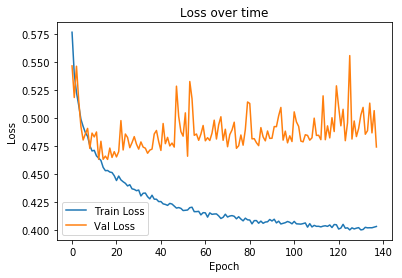

In [105]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(averaged_train_loss_hist)), averaged_train_loss_hist, label='Train Loss')
plt.plot(range(len(averaged_val_loss_history)), averaged_val_loss_history, label='Val Loss')
plt.legend()
fig.savefig('final_report_imgs/Loss over time (2 classes, 138 epochs) - Report.jpg')

In [56]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [95]:
print(len(train_hist)/138)
t_holder_0 = []
t_holder_1 = []
v_holder_0 = []
v_holder_1 = []
averaged_train_iou_0 = []
averaged_train_iou_1 = []
averaged_val_iou_0 = []
averaged_val_iou_1 = []
idx = 0
for iteration in range(len(val_hist)-1):
    t_holder_0.append(train_hist[iteration, 0])
    t_holder_1.append(train_hist[iteration, 1])
    v_holder_0.append(val_hist[iteration, 0])
    v_holder_1.append(val_hist[iteration, 1])
    if iteration % 26 == 0:
        averaged_train_iou_0.append(np.mean(np.asarray(t_holder_0)))
        averaged_train_iou_1.append(np.mean(np.asarray(t_holder_1)))
        averaged_val_iou_0.append(np.mean(np.asarray(v_holder_0)))
        averaged_val_iou_1.append(np.mean(np.asarray(v_holder_1)))
        t_holder_0.clear()
        t_holder_1.clear()
        v_holder_0.clear()
        v_holder_1.clear()

26.028985507246375


In [96]:
print(len(averaged_val_iou_1))

139


In [97]:
print(val_hist.shape)
print(train_hist.shape)
print(np.asarray(averaged_train_loss_hist).shape)

(3593, 2)
(3592, 2)
(138,)


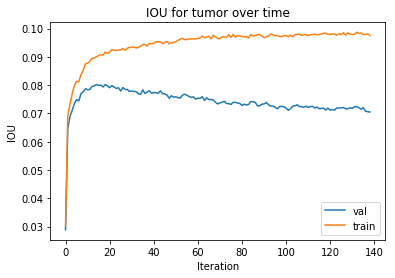

In [100]:
fig = plt.figure()
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_1)), averaged_val_iou_1, label='val')
plt.plot(range(len(averaged_train_iou_1)), averaged_train_iou_1, label='train')
plt.legend()
# fig.savefig('IOU for tumor - Poster Session.png')
fig.savefig('final_report_imgs/IOU for tumor (2 classes, 138 epochs) - Report.png')

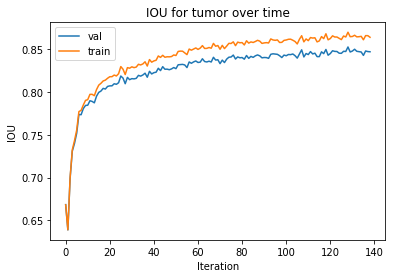

In [101]:
fig = plt.figure()
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_0)), averaged_val_iou_0, label='val')
plt.plot(range(len(averaged_train_iou_0)), averaged_train_iou_0, label='train')
plt.legend()
fig.savefig('final_report_imgs/IOU for no tumor (2 classes, 138 epochs) - Report.png')

In [103]:
binary_tumor_report_segmenation = []
binary_tumor_report_segmenation.append(averaged_train_loss_hist)
binary_tumor_report_segmenation.append(averaged_train_iou_0)
binary_tumor_report_segmenation.append(averaged_train_iou_1)
binary_tumor_report_segmenation.append(averaged_val_loss_history)
binary_tumor_report_segmenation.append(averaged_val_iou_0)
binary_tumor_report_segmenation.append(averaged_val_iou_1)

with open('data/pkl_files/binary_tumor_arrs.pkl', 'wb') as fp:
    pickle.dump(binary_tumor_report_segmenation, fp)


In [104]:
check_iou(test_loader, model)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


array([0.8351582, 0.0782272])

Overfitting small dataset

In [ ]:
small_inputs = inputs[:40]
small_outputs = outputs[:40]

np.random.seed(0)
shuffled_idxs = list(range(small_inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(small_inputs.shape[0]*80/100)

small_train_inputs = []
small_train_outputs = []
small_val_inputs = []
small_val_outputs = []


for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        small_train_inputs.append(small_inputs[idx])
        small_train_outputs.append(small_outputs[idx])
    else:
        small_val_inputs.append(small_inputs[idx])
        small_val_outputs.append(small_outputs[idx])

n_tumor_pixels = np.count_nonzero(np.asarray(small_train_outputs))
total_output_pixels = 32*32*32
frac_tumor = n_tumor_pixels / total_output_pixels


In [ ]:
small_train_inputs = np.asarray(small_train_inputs).astype(np.float32)
small_val_inputs = np.asarray(small_val_inputs).astype(np.float32)

small_train_inputs_mean = np.mean(small_train_inputs, axis=0)
small_train_inputs_std = np.std(small_train_inputs, axis=0)

small_train_inputs -= small_train_inputs_mean
small_train_inputs /= small_train_inputs_std
small_val_inputs -= small_train_inputs_mean
small_val_inputs /= small_train_inputs_std


In [ ]:
small_train_data = []
small_val_data = []
test_data = []

for idx in range(small_train_inputs.shape[0]):
    small_train_data.append([small_train_inputs[idx], small_train_outputs[idx]])
for idx in range(small_val_inputs.shape[0]):
    small_val_data.append([small_val_inputs[idx], small_val_outputs[idx]])

In [ ]:
print(len(small_train_data))
print(len(small_val_data))

In [ ]:
small_train_loader = torch.utils.data.DataLoader(small_train_data, shuffle=True, batch_size=32)
small_val_loader = torch.utils.data.DataLoader(small_val_data, shuffle=True, batch_size=32)


In [ ]:
print_every = 25
learning_rate = 1e-1
input_channels = 3
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 35]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 

# could try dice loss? not sure how it would work nor how it expects its parameters though lol

In [ ]:
val_iou_history = []
loss_history = []
train_iou_history = []
plot_every = 100
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    for e in range(epochs):
        for t, (x,y) in enumerate(small_train_loader):
            model.train()
            x = x.to(device='cuda', dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            scores = model(x)
            # print(scores.shape)

            loss = criterion(scores, labels)
            # loss = F.cross_entropy(scores, labels, weight=torch.FloatTensor([1/(float(26265600-1762336)), 1/(float(1762336))]).cuda())
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                val_iou = check_iou(small_val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(small_train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
train(model, optimizer, epochs=5000)

In [ ]:
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_history)), loss_history)

In [ ]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [ ]:
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()

In [ ]:
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()